# Lecture 20


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize
import sklearn.linear_model as lm

# plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

In [47]:
df = pd.read_csv('nba.csv')

In [48]:
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)

In [49]:
one_team = df.groupby("GAME_ID").first()
opponent = df.groupby("GAME_ID").last()
games = one_team.merge(opponent, left_index = True, right_index = True, suffixes = ["", "_OPP"])
games["FG_PCT_DIFF"] = games["FG_PCT"] - games["FG_PCT_OPP"]
games['WON'] = games['WL'].replace('L', 0).replace('W', 1)
games = games[['TEAM_NAME', 'MATCHUP', 'WON', 'FG_PCT_DIFF']]

In [50]:
bins = pd.cut(games["FG_PCT_DIFF"], 20)
games["bin"] = [(b.left + b.right) / 2 for b in bins]
win_rates_by_bin = games.groupby("bin")["WON"].mean()

In [51]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

## Logistic Regression with Squared Loss

We've chosen a model. It's now time to choose a loss function. Why not squared loss?

In [52]:
def mse_loss_single_arg_nba(theta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(x * theta)
    return np.mean((y_hat - y_obs) ** 2)  

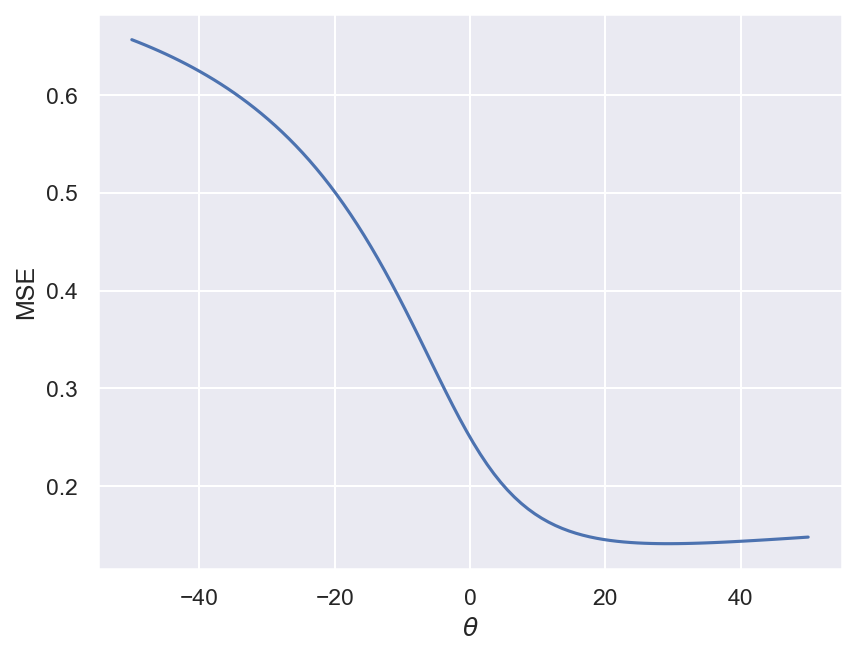

In [53]:
thetas = np.linspace(-50, 50, 100)
plt.plot(thetas, [mse_loss_single_arg_nba(theta) for theta in thetas])
plt.ylabel('MSE')
plt.xlabel(r'$\theta$');

In [54]:
minimize(mse_loss_single_arg_nba, x0 = 0)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.14105789850974032
        x: [ 2.913e+01]
      nit: 7
      jac: [-8.788e-06]
 hess_inv: [[ 1.272e+04]]
     nfev: 24
     njev: 12

In [55]:
minimize(mse_loss_single_arg_nba, x0 = 500)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.1410573027635218
        x: [ 2.925e+01]
      nit: 1
      jac: [-1.239e-06]
 hess_inv: [[1]]
     nfev: 54
     njev: 27

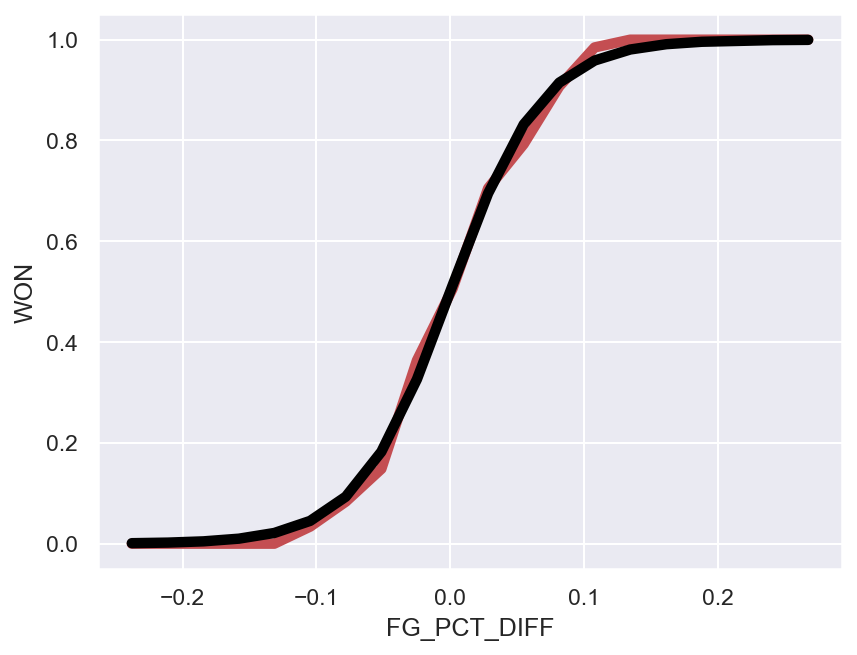

In [56]:
plt.plot(win_rates_by_bin, 'r', linewidth = 5);
x = win_rates_by_bin.index
plt.plot(x, sigma(x * 29.13), 'black', linewidth = 5);
plt.xlabel('FG_PCT_DIFF')
plt.ylabel('WON');

So squared loss worked just fine here. But that won't always be the case! Consider this manufacturered example.

In [57]:
rand_x = np.array([[-0.04185564],
       [ 0.12799961],
       [-0.09528101],
       [-0.0058139 ],
       [ 0.0870956 ]])

rand_y = np.array([[0],
       [0],
       [1],
       [0],
       [1]])

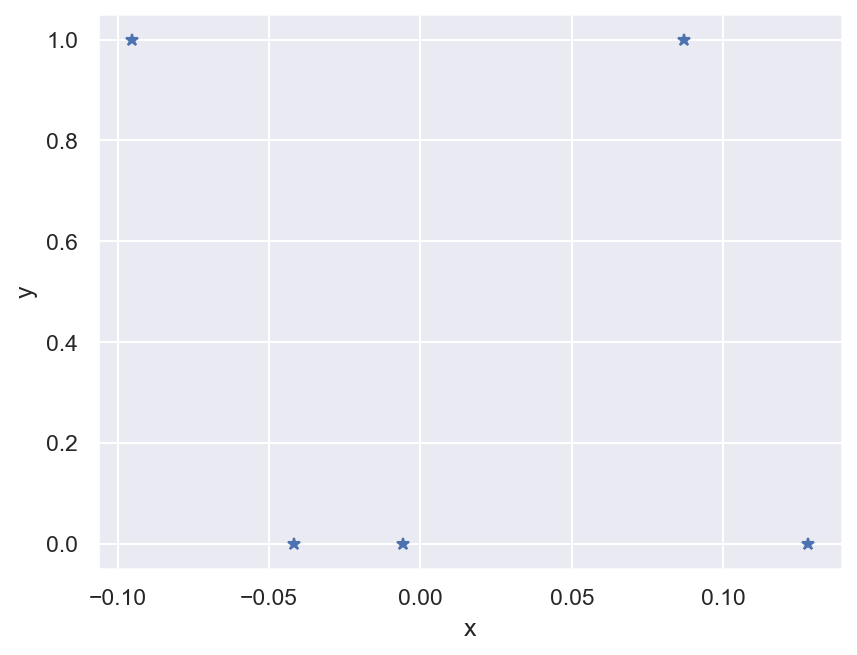

In [58]:
plt.plot(rand_x, rand_y, 'b*')
plt.xlabel('x')
plt.ylabel('y');

In [59]:
def mse_loss_single_arg_toy(theta):
    x = rand_x
    y_obs = rand_y
    y_hat = sigma(x * theta)
    return np.mean((y_obs - y_hat)**2)

In [60]:
mse_loss_single_arg_toy(10)

0.3226572801334151

Let's plot the loss surface for this toy data using squared loss with the model $\hat{y} = \sigma(\theta x)$, where $\theta$ and $x$ are both scalars.

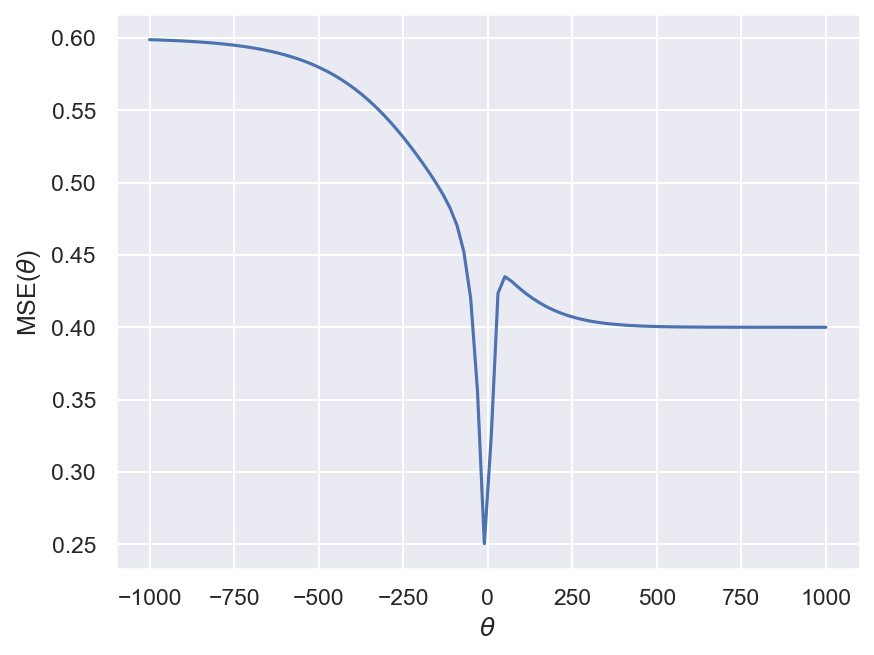

In [61]:
thetas = np.linspace(-1000, 1000, 100)
plt.plot(thetas, [mse_loss_single_arg_toy(theta) for theta in thetas])
plt.ylabel(r'MSE($\theta$)')
plt.xlabel(r'$\theta$');

This loss surface is not convex! Depending on where we start our optimization search, we'll end up with different results. Let's explore with `scipy.optimize.minimize`.

In [62]:
best_theta = minimize(mse_loss_single_arg_toy, x0 = 0)["x"][0]
best_theta

-4.801981341432673

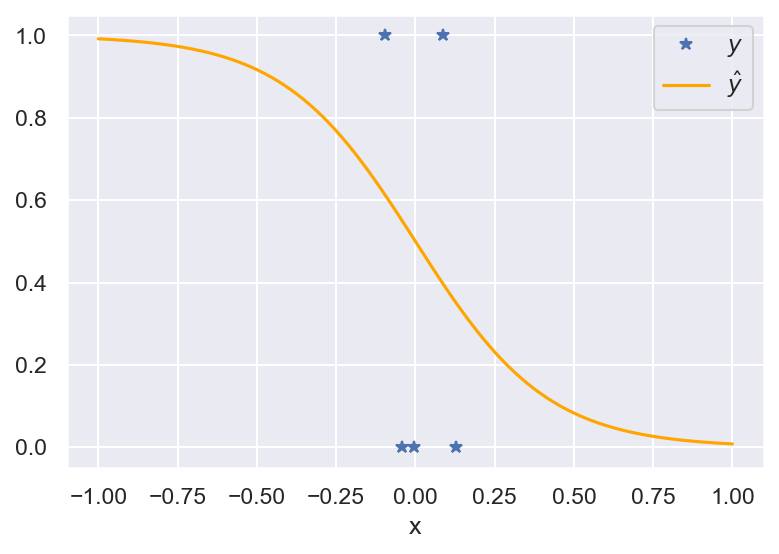

In [40]:
plt.plot(rand_x, rand_y, 'b*')
xs = np.linspace(-1, 1, 100)
plt.plot(xs, sigma(xs * best_theta), color='orange')
plt.xlabel('x')
plt.legend(['$y$', '$\hat{y}$']);

In [63]:
best_theta_2 = minimize(mse_loss_single_arg_toy, x0 = 500)["x"][0]
best_theta_2

500.0

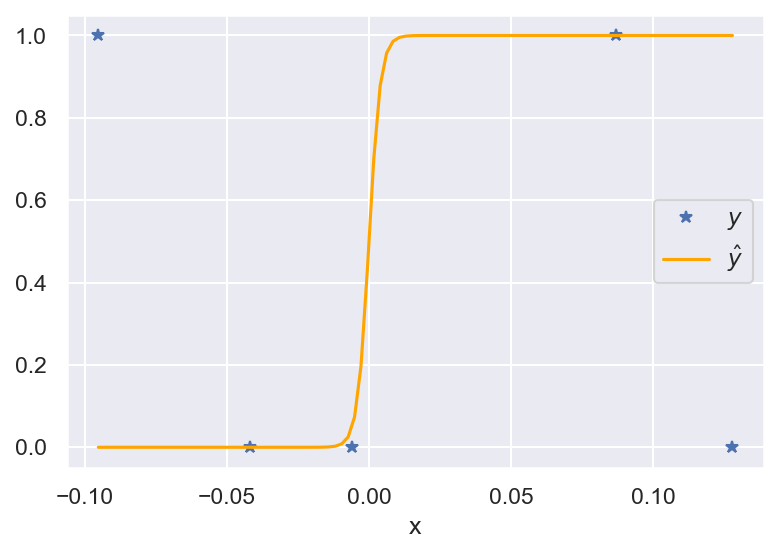

In [42]:
plt.plot(rand_x, rand_y, 'b*')
xs = np.linspace(min(rand_x), max(rand_x), 100)
plt.plot(xs, sigma(xs * best_theta_2), color='orange')
plt.xlabel('x')
plt.legend(['$y$', '$\hat{y}$']);

Not only is it not convex, leading to the weird issues above, but squared loss just isn't well-suited for a probability task. Since $\hat{y_i}$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{y_i})^2$ is bounded between 0 and 1.

What this means in practice: even if our prediction is terrible, the squared loss is never that large.

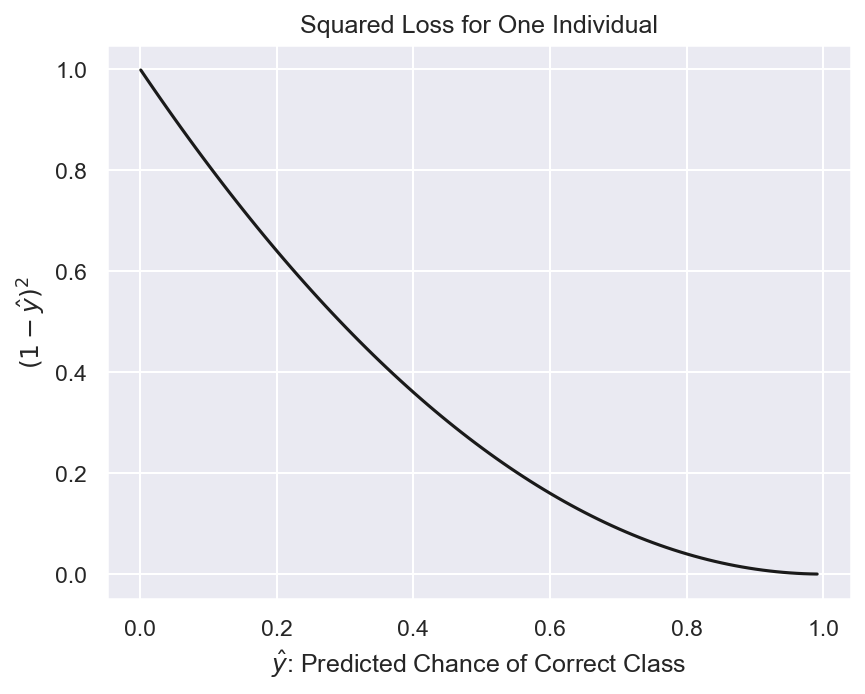

In [64]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = (1 - y_hat)**2
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$(1 - \hat{y})^2$')
plt.title('Squared Loss for One Individual');

## Motivating Cross-Entropy Loss

Let's look at a new loss, called the log loss, for when our true observation is 1.

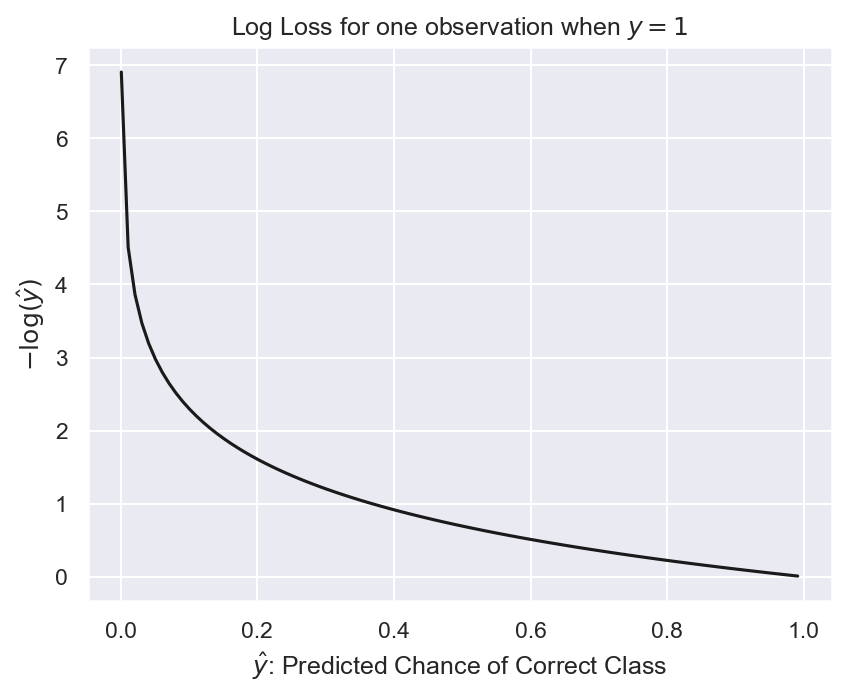

In [65]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(y_hat)
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{y})$')
plt.title('Log Loss for one observation when $y = 1$');

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: Suppose the observation we're trying to predict is actually in class 1. If our model gives an 80% chance of being in class 1, the loss is relatively small (around 0.25). 

If we give only a 40% of being in class 1, the loss is larger (around 1).

If we give only a 5% chance of being in class 1, the loss is 3.

And if we give a 0% chance of being in class 1, the loss is infinite.

What about when the true observation is 0?

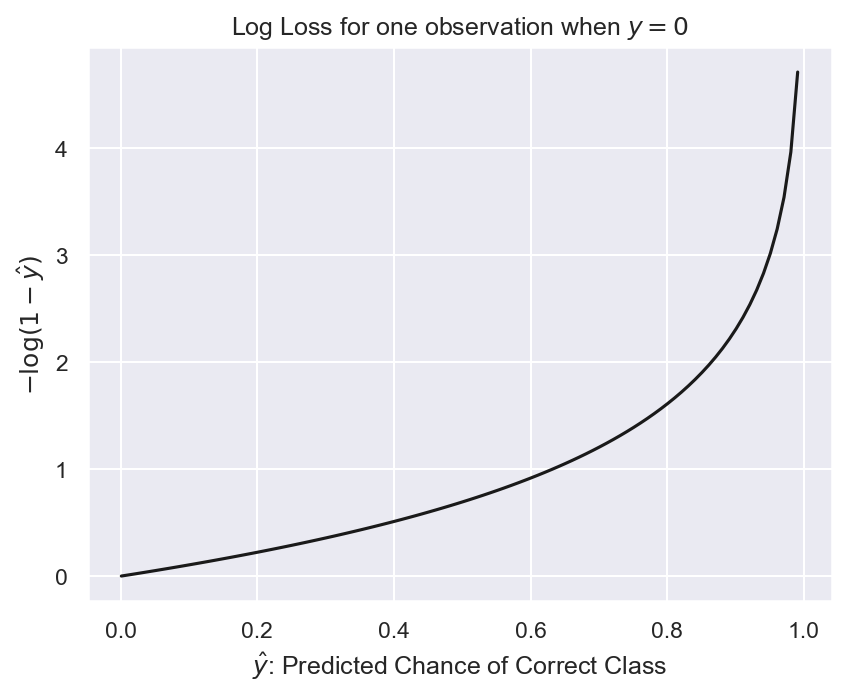

In [66]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(1 - y_hat)
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(1 - \hat{y})$')
plt.title('Log Loss for one observation when $y = 0$');

Much of the formal derivation is in the slides. But the equation for cross-entropy loss for a single observation is

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss, on our toy data from before.

In [67]:
def cross_entropy(y, yhat):
    return - y * np.log(yhat) - (1 - y) * np.log(1 - yhat)

In [68]:
def mce_loss_single_arg_toy(theta):
    x = rand_x
    y_obs = rand_y
    y_hat = sigma(x * theta)
    return np.mean(cross_entropy(y_obs, y_hat))

/var/folders/w7/5j9sp5kd0nv96pdk3dvg9wt00000gq/T/ipykernel_47372/529625363.py:2: RuntimeWarning:

divide by zero encountered in log

/var/folders/w7/5j9sp5kd0nv96pdk3dvg9wt00000gq/T/ipykernel_47372/529625363.py:2: RuntimeWarning:

invalid value encountered in multiply



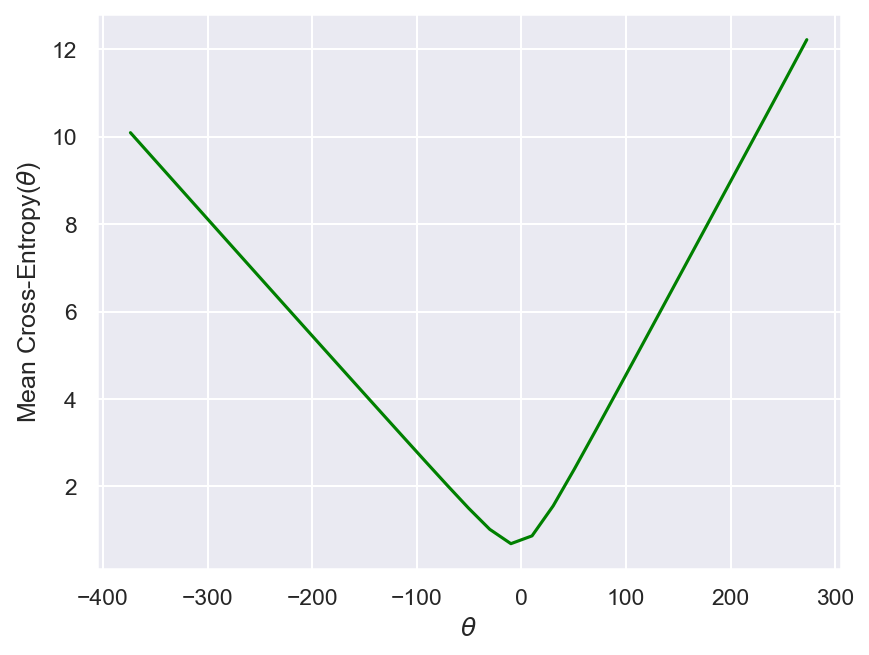

In [69]:
thetas = np.linspace(-1000, 1000, 100)
plt.plot(thetas, [mce_loss_single_arg_toy(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');

In [70]:
best_theta_mce = minimize(mce_loss_single_arg_toy, x0 = 0)["x"][0]
best_theta_mce

-5.213601516313596

We see the resulting optimal $\hat{\theta}$ is slightly different than the one that minimized MSE:

In [71]:
best_theta

-4.801981341432673

And lastly, we can determine the $\hat{\theta}$ that minimizes mean cross-entropy loss for our NBA dataset from earlier:

In [72]:
def mce_loss_single_arg_nba(theta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(theta * x)
    return np.mean(cross_entropy(y_obs, y_hat))

In [73]:
best_theta_mce_nba = minimize(mce_loss_single_arg_nba, x0 = 0)["x"][0]
best_theta_mce_nba

30.578808323155144

Again, this is different than the $\hat{\theta}$ that minimizes mean squared error for the NBA dataset:

In [74]:
minimize(mse_loss_single_arg_nba, x0 = 0)["x"][0]

29.130078012616185

## Predicting Probabilities

We can manually call `scipy.optimize.minimize` to determine the model parameters that minimize average cross-entropy loss, as we did above. We can then predict probabilities.

In [54]:
best_theta_mce_nba = minimize(mce_loss_single_arg_nba, x0 = 0)["x"][0]
best_theta_mce_nba

30.578971781696595

In [75]:
def predict_probabilities(X, theta):
    return sigma(X * theta)

In [56]:
predict_probabilities(games['FG_PCT_DIFF'], best_theta_mce_nba)

GAME_ID
21700001    0.182669
21700002    0.834890
21700003    0.285494
21700004    0.777946
21700005    0.783184
              ...   
21701226    0.996919
21701227    0.891866
21701228    0.627111
21701229    0.059968
21701230    0.048978
Name: FG_PCT_DIFF, Length: 1230, dtype: float64

Once again, `scikit-learn` can do this for us.

The `lm.LogisticRegression` model is what we want to use here. In order to recreate our specific model, there are a few parameters we need to set:
- `penalty = 'none'`: by default, `lm.LogisticRegression` uses regularization. This is generally a good idea, but we haven't yet covered regularization with logistic regression.
- `fit_intercept = False`: our toy model does not currently have an intercept term.
- `solver = 'lbgfs'`: need to specify a numerical optimization routine for the model (similar to gradient descent). `lbfgs` is one such type, and it's the new default in `scikit-learn`.

In [76]:
model = lm.LogisticRegression(penalty = 'none', fit_intercept = False, solver = 'lbfgs')

In [77]:
model.fit(games[['FG_PCT_DIFF']], games['WON'])

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



LogisticRegression(fit_intercept=False, penalty='none')

We can see that the optimal theta (here there's just one, because our model only has one feature) found via `scikit-learn` is the same that we found manually before. (Small deviations due to numerical precision issues.)

In [78]:
model.coef_

array([[30.57950163]])

In [79]:
best_theta_mce_nba

30.578808323155144

`scikit-learn` has a built-in `.predict_proba` method that allows us to get the predicted probabilities under our model.

In [80]:
model.predict_proba([[0.1]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([[0.04487548, 0.95512452]])

This is saying that if `FG_PCT_DIFF = 0.1`, that is, if you shoot 10% better than your opponent, there is a 95.5% chance you will win.

We can also apply this to our entire training set at once.

In [81]:
model.predict_proba(games[['FG_PCT_DIFF']])

array([[0.81733506, 0.18266494],
       [0.16510648, 0.83489352],
       [0.71450899, 0.28549101],
       ...,
       [0.37288695, 0.62711305],
       [0.94003495, 0.05996505],
       [0.95102413, 0.04897587]])

In [63]:
model.predict_proba(games[['FG_PCT_DIFF']])[:, 1]

array([0.18266494, 0.83489352, 0.28549101, ..., 0.62711305, 0.05996505,
       0.04897587])

These values are the same as we computed manually above, as well!

In [82]:
predict_probabilities(games['FG_PCT_DIFF'], best_theta_mce_nba)

GAME_ID
21700001    0.182670
21700002    0.834888
21700003    0.285495
21700004    0.777945
21700005    0.783183
              ...   
21701226    0.996919
21701227    0.891865
21701228    0.627110
21701229    0.059969
21701230    0.048979
Name: FG_PCT_DIFF, Length: 1230, dtype: float64

## Making Classifications

`scikit-learn` also has an in-built `.predict` method. Let's see what it does:

In [83]:
model.predict(games[['FG_PCT_DIFF']])

array([0, 1, 0, ..., 1, 0, 0])

How did it come up with these 1s and 0s?